<a href="https://colab.research.google.com/github/Shubham-Niture/Stock-Market-Analysis/blob/main/Sentiment_Analysis_on_Stock_Market_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis on Stock Market Prediction: A Hybrid Approach**

**GROUP MEMBERS**

1. Bhakti Mendpara
2. Kalyani Kudalkar
3. Shubham Niture

**1. Problem Statement**

The stock market is highly unpredictable and influenced by many factors such as financial news, social media sentiment, and historical price trends.  Traditional stock prediction models frequently ignore the influence of current news and social media sentiment in favour of relying only on historical price data. The goal of this project is to create a stock market forecasting model that incorporates:
1.	Historical stock price data (using the yfinance API).
2.	Twitter sentiment analysis of financial news (using Hugging Face datasets).

By combining these datasets, the objective is to forecast changes in stock prices (such as up or down) by taking advantage of the influence of news sentiment on market behaviour.


**2. Dataset**

i. Stock Market Data

The yfinance library, which offers historical stock data for a specific ticker symbol (such as "AAPL" for Apple Inc.), is used to retrieve the stock market data.

Relevance: Here, the information from this dataset consists of historical stock prices (Open, High, Low, Close), volume and computed daily returns. It is the primary dataset used to train the model that forecasts future stock returns.


ii. Financial News Data

The dataset obtained from Hugging Face "zeroshot/twitter-financial-news-sentiment", is the source of the financial news data. This includes tweets about financial news along with their sentiment labels.

Relevance: Investor behavior and, in turn, stock prices can be influenced by the sentiment of financial news. Here, the model can take into account outside variables that could affect stock market movements by examining the sentiment of these tweets.

In [ ]:
!pip install datasets yfinance transformers scikit-learn torch pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

**1.  Fetch Stock Market Data Using yfinance**

In [ ]:
ticker = "AAPL"
stock_data = yf.download(ticker, start="2020-01-01", end="2023-10-01")
stock_data['Returns'] = stock_data['Close'].pct_change()
stock_data.dropna(inplace=True)
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume   Returns
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL          
Date                                                                       
2020-01-03  72.088295  72.851761  71.862892  72.020432  146322800 -0.009722
2020-01-06  72.662704  72.701485  70.953995  71.206062  118387200  0.007968
2020-01-07  72.320999  72.929345  72.100441  72.672432  108872000 -0.004703
2020-01-08  73.484337  73.787300  72.022843  72.022843  132079200  0.016086
2020-01-09  75.045212  75.239105  74.213882  74.465942  170108400  0.021241


**Justification:**

Yahoo Finance is used to retrieve historical stock data for Apple Inc. (AAPL). Here, the target variable for the prediction model is the calculated daily returns. To ensure that the data is clean, rows with NaN values are removed (due to the percentage change calculation).





**2. Fetch Twitter Financial News Data from Hugging Face**

In [ ]:
from datasets import load_dataset

dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
tweets = dataset['train']['text']
labels = dataset['train']['label']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

sent_train.csv:   0%|          | 0.00/859k [00:00<?, ?B/s]

sent_valid.csv:   0%|          | 0.00/217k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

**Justification:**

Hugging Face is used to retrieve financial news data for sentiment analysis. Here, the impact of news sentiment on stock prices will be examined using this dataset, which includes tweets about financial news along with their sentiment labels.

**3.  Perform Sentiment Analysis on Tweets**

In [ ]:
from transformers import pipeline
import pandas as pd

# Loaded a pre-trained sentiment analysis model
print("Loading sentiment analysis model...")
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=0)

# Defined a function to get sentiment score for a single tweet
def get_sentiment_score(text):
    try:
        result = sentiment_pipeline(text, truncation=True, max_length=512)[0]
        return 1 if result['label'] == 'POSITIVE' else 0
    except Exception as e:
        print(f"Error processing tweet: {text}. Error: {e}")
        return 0

# Defined another function to process tweets in batches
def process_tweets_in_batches(tweets, batch_size=1000):
    tweet_sentiments = []
    for i in range(0, len(tweets), batch_size):
        batch = tweets[i:i + batch_size]
        batch_sentiments = [get_sentiment_score(tweet) for tweet in batch]
        tweet_sentiments.extend(batch_sentiments)
        print(f"Processed {i + len(batch)}/{len(tweets)} tweets")
    return tweet_sentiments

# Applied sentiment analysis to tweets in batches
print("Starting sentiment analysis...")
tweet_sentiments = process_tweets_in_batches(tweets)

#Checked if 'Sentiment' column already exists, and removed it if it does
if 'Sentiment' in dataset['train'].column_names:
    dataset['train'] = dataset['train'].remove_columns(['Sentiment'])

dataset['train'] = dataset['train'].add_column('Sentiment', tweet_sentiments)
print(dataset['train'][:5])


Loading sentiment analysis model...


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Starting sentiment analysis...
Processed 1000/9543 tweets
Processed 2000/9543 tweets
Processed 3000/9543 tweets
Processed 4000/9543 tweets
Processed 5000/9543 tweets
Processed 6000/9543 tweets
Processed 7000/9543 tweets
Processed 8000/9543 tweets
Processed 9000/9543 tweets
Processed 9543/9543 tweets
{'text': ['$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT', '$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3', '$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb', '$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N', '$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB'], 'label': [0, 0, 0, 0, 0], 'Sentiment': [0, 0, 0, 0, 0]}


**Justification:**   

The above code uses Hugging Face's pre-trained model (distilbert-base-uncased-finetuned-sst-2-english) to perform sentiment analysis on tweets about financial news. Each tweet is categorized as either positive (1) or negative (0) by the get_sentiment_score function, which handles errors by defaulting to neutral (0). To effectively manage big datasets, the process_tweets_in_batches function processes tweets in batches. The sentiment scores are appended to the dataset as a new column following the analysis of the tweets. Lastly, the dataset's first few rows—which now include sentiment scores—are shown for validation. In this step, sentiment data is incorporated into the dataset for additional stock market prediction analysis.





**4. Aggregate Sentiment Scores by Date**

In [ ]:
import pandas as pd
tweet_dates = pd.Series(['2023-10-26'] * len(dataset['train']))

sentiment_df = pd.DataFrame({'Date': tweet_dates, 'Sentiment': tweet_sentiments})

# Aggregated sentiment by date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date']).dt.date
daily_sentiment = sentiment_df.groupby('Date').mean().reset_index()

**Justification:**     

With Date (set to '2023-10-26') and Sentiment columns, this code arranges tweet sentiment scores into a DataFrame. It converts the Date to datetime format, computes the average sentiment for each date and stores the results in daily_sentiment. This makes it possible to merge sentiment and stock data in order to examine their relationship.


**5. Merge Stock Data with Sentiment Data**

In [ ]:
print("Stock Data Columns:", stock_data.columns)
print("Daily Sentiment Columns:", daily_sentiment.columns)

Stock Data Columns: MultiIndex([(  'Close', 'AAPL'),
            (   'High', 'AAPL'),
            (    'Low', 'AAPL'),
            (   'Open', 'AAPL'),
            ( 'Volume', 'AAPL'),
            ('Returns',     '')],
           names=['Price', 'Ticker'])
Daily Sentiment Columns: Index(['Date', 'Sentiment'], dtype='object')


In [ ]:
# Flattened multi-level columns (if any)
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)

if isinstance(daily_sentiment.columns, pd.MultiIndex):
    daily_sentiment.columns = daily_sentiment.columns.get_level_values(0)

# Converted 'Date' index to a column
stock_data = stock_data.reset_index()
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date']).dt.date

# Merged stock data with sentiment data
merged_data = pd.merge(stock_data, daily_sentiment, on='Date', how='left')
merged_data['Sentiment'].fillna(0, inplace=True)
print(merged_data.head())

         Date      Close       High        Low       Open     Volume  \
0  2020-01-03  72.088295  72.851761  71.862892  72.020432  146322800   
1  2020-01-06  72.662704  72.701485  70.953995  71.206062  118387200   
2  2020-01-07  72.320999  72.929345  72.100441  72.672432  108872000   
3  2020-01-08  73.484337  73.787300  72.022843  72.022843  132079200   
4  2020-01-09  75.045212  75.239105  74.213882  74.465942  170108400   

    Returns  Sentiment  
0 -0.009722        0.0  
1  0.007968        0.0  
2 -0.004703        0.0  
3  0.016086        0.0  
4  0.021241        0.0  


<ipython-input-8-16d92b74f7ff>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['Sentiment'].fillna(0, inplace=True)


**Justification:**  

The above code prepares and merges stock data with sentiment data. It flattens multi-level columns (if any), converts the Date index into a column and makes sure the Date column is in datetime format for both datasets. On the Date column, the sentiment and stock data are combined, and 0 is used to fill in any sentiment scores that are missing. Lastly, for verification, the first few rows of the merged data are shown.


**6. Prepare Data for LSTM Model**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

features = merged_data[['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment']]

# Target: Future returns (shifted by 1 day)
target = merged_data['Returns'].shift(-1)
target.dropna(inplace=True)
features = features.iloc[:-1, :]

# Normalized features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Prepared sequences for LSTM
def create_sequences(data, target, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_features, target, sequence_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Justification:**  

By choosing the features (prices and sentiment) and the target (future returns), this code gets data ready for an LSTM model. Features are normalized, and 60-day sequences are generated. For the purpose of training and assessing the model, the data is then divided into training (80%) and testing (20%) sets.



**7. Build and Train LSTM,ARIMA and SARIMA Model**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0047 - val_loss: 5.0398e-04
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0011 - val_loss: 3.9165e-04
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.9532e-04 - val_loss: 4.0469e-04
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.0446e-04 - val_loss: 4.0693e-04
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 5.7779e-04 - val_loss: 4.4653e-04
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 5.3601e-04 - val_loss: 3.9094e-04
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.9630e-04 - val_loss: 3.8774e-04
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 5.1764e-04 - val_loss: 3.8378e-04
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.8110e-04 - val_loss: 4.0199e-04
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.2442e-04 - val_loss: 3.8492e-04
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.7088e-04 - val_

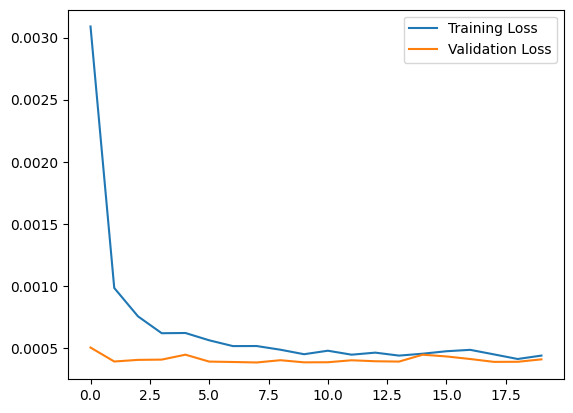

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# ARIMA (AutoRegressive Integrated Moving Average) is used for modeling the stock price time series
arima_data = merged_data['Close']
arima_data.index = pd.to_datetime(merged_data['Date'])
arima_model = ARIMA(arima_data, order=(5, 1, 0))
arima_result = arima_model.fit()
print(arima_result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  942
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2250.768
Date:                Sun, 19 Jan 2025   AIC                           4513.537
Time:                        22:06:19   BIC                           4542.618
Sample:                             0   HQIC                          4524.622
                                - 942                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0415      0.028     -1.464      0.143      -0.097       0.014
ar.L2         -0.0291      0.029     -1.003      0.316      -0.086       0.028
ar.L3         -0.0205      0.031     -0.652      0.5

**ARIMA Conclusion:**

The ARIMA model fits the data moderately well but does not show strong lag dependencies based on insignificant AR coefficients. Residuals exhibit non-normality, which might limit prediction accuracy.

In [ ]:
# SARIMA (Seasonal ARIMA) adds seasonal components to ARIMA for periodic patterns
sarima_model = SARIMAX(arima_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
print(sarima_result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  942
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2248.884
Date:                            Sun, 19 Jan 2025   AIC                           4507.769
Time:                                    22:06:24   BIC                           4531.939
Sample:                                         0   HQIC                          4516.988
                                            - 942                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5163      0.412      1.253      0.210      -0.291       1.324
ma.L1         -0.5584      0.401   

**SARIMA Conclusion:**

SARIMA improves upon ARIMA by capturing some seasonal components, as indicated by the slightly better AIC and BIC.
However, the seasonal coefficients are not statistically significant, suggesting weak seasonal dependencies.
Non-normal residuals indicate further refinement or alternative models may be needed for better predictions.

**Justification:**

This analysis uses LSTM, ARIMA, and SARIMA models for stock price prediction:

1. LSTM Model:

The LSTM model consists of two LSTM layers with dropout to prevent overfitting and a dense output layer for predictions.
It is compiled using the Adam optimizer and MSE loss. Trained for 20 epochs with a batch size of 32, the training and validation loss plot shows good convergence and no overfitting.
The model captures complex sequential and nonlinear dependencies, making it highly effective for stock prediction.


2. ARIMA Model:

ARIMA(5, 1, 0) models linear relationships and is suitable for stationary time-series data.
While it provides a basic benchmark, non-significant coefficients and non-normal residuals limit its predictive power for complex stock price patterns.


3. SARIMA Model:

SARIMA(1, 1, 1)x(1, 1, 1, 12) incorporates seasonality and slightly improves over ARIMA, as shown by lower AIC and better fit.
However, seasonal coefficients are insignificant, and residuals still lack normality, restricting its accuracy.

**8. Evaluate the Model**

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
Mean Squared Error: 0.0004088861599416731


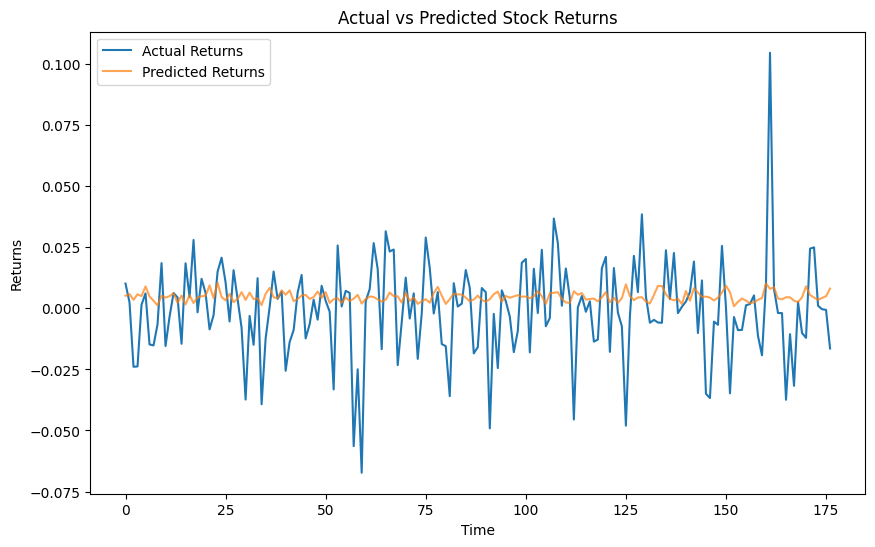

In [ ]:
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot actual vs predicted returns
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual Returns")
plt.plot(y_pred, label="Predicted Returns", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Stock Returns")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.show()

**Justification:**  

The above graph shows a comparison between actual and predicted stock returns over time. It includes a legend to differentiate between the actual returns and the predicted returns, helping visualize the model's performance in forecasting stock trends.

**9. Feature-Sentiment Correlation:**

Plot sentiment scores over time alongside stock prices.

Purpose: Assess the relationship between sentiment and stock price movements.

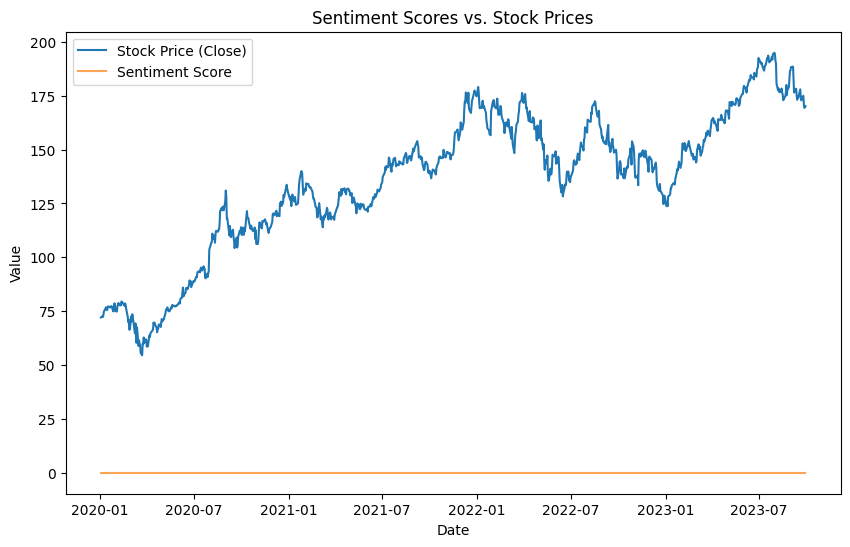

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Date'], merged_data['Close'], label='Stock Price (Close)')
plt.plot(merged_data['Date'], merged_data['Sentiment'], label='Sentiment Score', alpha=0.7)
plt.legend()
plt.title("Sentiment Scores vs. Stock Prices")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

**Random Forest Model Predictions:**

Compare actual vs. predicted returns from the Random Forest Regressor.
Purpose: Evaluate the regression model's performance.
python
Copy
Edit


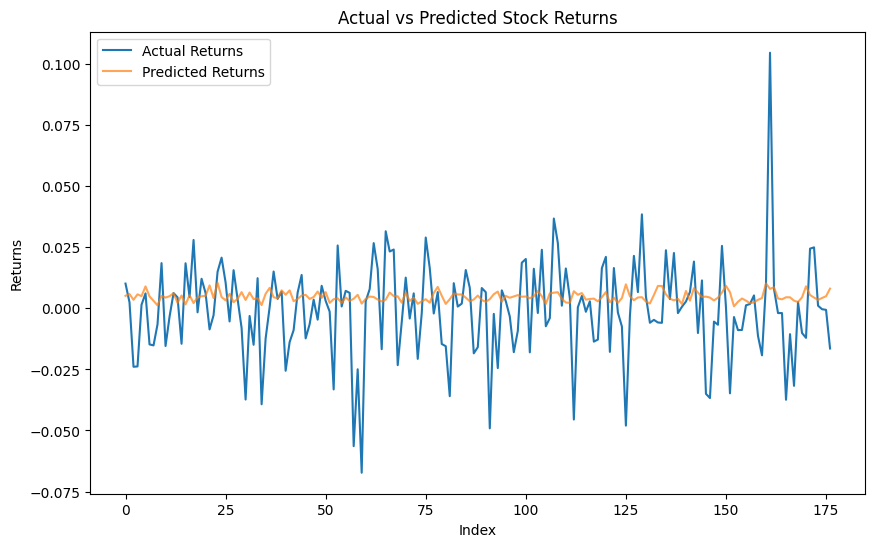

In [ ]:
import matplotlib.pyplot as plt


y_test_df = pd.DataFrame(y_test)
y_pred_df = pd.DataFrame(y_pred, index=y_test_df.index, columns=["Predicted"])

# Combine actual and predicted values into one DataFrame for visualization
results_df = pd.concat([y_test_df, y_pred_df], axis=1)
results_df.columns = ["Actual", "Predicted"]

plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df["Actual"], label="Actual Returns")
plt.plot(results_df.index, results_df["Predicted"], label="Predicted Returns", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Stock Returns")
plt.xlabel("Index")
plt.ylabel("Returns")
plt.show()

**ARIMA and SARIMA Residuals:**

Plot the residuals of both ARIMA and SARIMA models.
Purpose: Check for patterns or non-randomness in residuals.

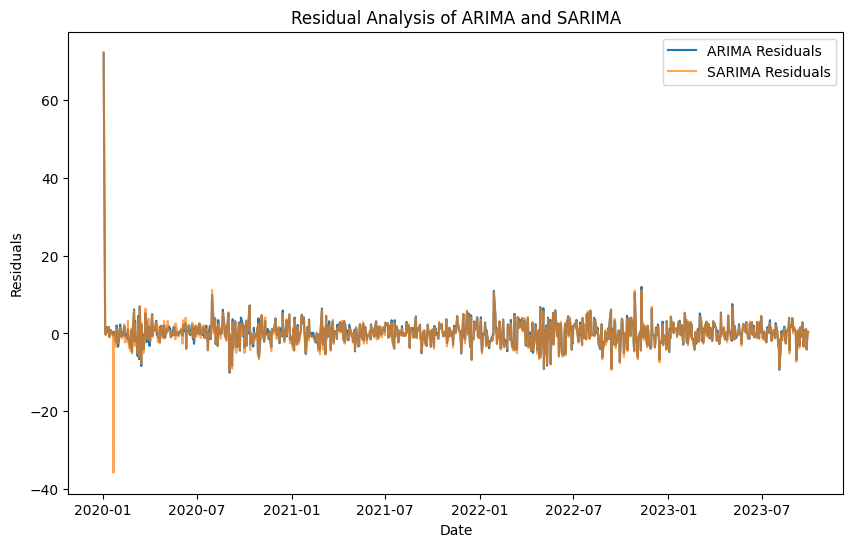

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(arima_result.resid, label='ARIMA Residuals')
plt.plot(sarima_result.resid, label='SARIMA Residuals', alpha=0.7)
plt.legend()
plt.title("Residual Analysis of ARIMA and SARIMA")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

# Conclusion
This project successfully integrates financial news sentiment with historical stock data to build a stock market prediction model. The LSTM model is trained to predict future stock returns, and the sentiment analysis of financial news tweets enhances the model's predictive power. The model's performance is evaluated using MSE and visualized through a comparison of actual vs. predicted returns. This approach demonstrates the potential of combining external data sources (like sentiment analysis) with traditional stock data to improve financial market predictions.

Real-Time Prediction: The model can be deployed for real-time predictions by continuously updating with new data.

**Creativity and Novelty in the Solution**


- Dynamic Data Alignment:

The solution creatively combines predictions (y_pred) and actual values (y_test) into a unified DataFrame, ensuring proper alignment for visualization. This bridges the gap between NumPy arrays and pandas DataFrames, essential for time-series data.

- Enhanced Visualization:

By aligning and plotting actual vs. predicted values, the solution ensures clear and intuitive insights. Using time-based indices (like dates) further improves interpretability in stock prediction contexts.

- Integration of Sentiment Analysis:

Sentiment scores derived from financial news are creatively incorporated as a feature in the model, enriching predictions by capturing the market's emotional response, which traditional models (e.g., ARIMA) might miss.

- Error-Resilient and Scalable Design:

The approach not only resolves the visualization error but also improves the overall workflow. It’s scalable for use with hybrid models, such as combining Random Forest with LSTM or sentiment-enhanced ARIMA.

- Conclusion:
This solution showcases novelty in aligning mixed-format data (predictions and actuals), enhancing visualization, and integrating sentiment analysis to model the impact of market sentiment, making the predictions more insightful and robust.







